In [10]:
import os, re, sys, arxiv, csv

def fix_title(title: str) -> str:
    return re.sub(r'[<>:"/\\|?*]', "_", re.sub(r"\s*\n+\s*", " ", title))

def paper_to_filename(paper: arxiv.Result) -> str:
    author_str = str(paper.authors[0]) + " et al." * (len(paper.authors) > 1)
    return f"{author_str} - {fix_title(paper.title)}.pdf"

def parse_line(line: str):
    m = re.match(r".*(?P<paper_id>\d{4}\.\d{4,6}(v\d+)?)(\.pdf)?$", line)
    return m.group("paper_id") if m is not None else None

In [11]:
import pandas as pd
paper_df = pd.DataFrame(columns=['date', 'title', 'authors', 'abstract', 'url'])
with open("deepmind_RL_research.csv", 'r') as file:
    csvreader = csv.reader(file)
    paper_ids = [parse_line(row[0]) for row in csvreader]
    paper_ids = [x for x in paper_ids if x is not None]
    papers = arxiv.Search(id_list=paper_ids).results()

    # print(len(paper_ids))
    for paper, paper_id in zip(papers, paper_ids):
        paper_df.loc[len(paper_df.index)] = [paper.published, str(paper.title), [str(x) for x in paper.authors], str(paper.summary), paper.entry_id]
        # print(f"file:    {dst_filename}")
        # print(f"abstract: {paper.summary}")
        # print(f"url:     {paper.entry_id}")
        # print(f"authors: {[str(x) for x in paper.authors]}")
        # print(f"title:   {paper.title}\n")

In [13]:
paper_df.head()

,date,title,authors,abstract,url
0,2023-02-13 04:02:53+00:00,Universal Agent Mixtures and the Geometry of I...,"[Samuel Allen Alexander, David Quarel, Len Du,...",Inspired by recent progress in multi-agent Rei...,http://arxiv.org/abs/2302.06083v1
1,2023-02-09 15:22:09+00:00,Scaling Goal-based Exploration via Pruning Pro...,"[Akhil Bagaria, Ray Jiang, Ramana Kumar, Tom S...",One of the gnarliest challenges in reinforceme...,http://arxiv.org/abs/2302.04693v1
2,2023-03-07 16:25:52+00:00,Exploration via Epistemic Value Estimation,"[Simon Schmitt, John Shawe-Taylor, Hado van Ha...",How to efficiently explore in reinforcement le...,http://arxiv.org/abs/2303.04012v1
3,2023-01-29 18:21:05+00:00,Distilling Internet-Scale Vision-Language Mode...,"[Theodore Sumers, Kenneth Marino, Arun Ahuja, ...",Instruction-following agents must ground langu...,http://arxiv.org/abs/2301.12507v2
4,2022-09-28 20:49:34+00:00,Optimistic Posterior Sampling for Reinforcemen...,"[Daniil Tiapkin, Denis Belomestny, Daniele Cal...",We consider reinforcement learning in an envir...,http://arxiv.org/abs/2209.14414v1


In [22]:
import os 
from PyPDF2 import PdfReader

docs = []
filenames = os.listdir('Papers')
for filename in filenames: 
    text = ''
    reader = PdfReader(f'Papers/{filename}')  
    for page in reader.pages:
        text += page.extract_text() 
    docs.append(text)

FloatObject (b'0.00-10') invalid; use 0.0 instead
FloatObject (b'0.00-10') invalid; use 0.0 instead
FloatObject (b'0.00-10') invalid; use 0.0 instead
FloatObject (b'0.00-10') invalid; use 0.0 instead


In [24]:
from top2vec import Top2Vec

In [25]:
model = Top2Vec(docs)

2023-10-03 00:12:59,289 - top2vec - INFO - Pre-processing documents for training


2023-10-03 00:13:03,601 - top2vec - INFO - Creating joint document/word embedding
2023-10-03 00:14:54,273 - top2vec - INFO - Creating lower dimension embedding of documents
2023-10-03 00:14:56,817 - top2vec - INFO - Finding dense areas of documents
2023-10-03 00:14:56,825 - top2vec - INFO - Finding topics


In [27]:
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

[138  59]


In [28]:
topic_words, word_scores, topic_nums = model.get_topics()

In [29]:
for words, scores, num in zip(topic_words, word_scores, topic_nums):
    print(num)
    print(f"Words: {words}")

0
Words: ['mnih' 'deep' 'atari' 'learning' 'networks' 'recurrent' 'transfer'
 'visual' 'tasks' 'prioritized' 'progress' 'replay' 'architectures'
 'memory' 'representations' 'multitask' 'scene' 'control' 'bellemare'
 'unsupervised' 'robot' 'images' 'mirowski' 'architecture'
 'representation' 'neural' 'learn' 'silver' 'rich' 'schaul' 'distributed'
 'rainbow' 'features' 'robotics' 'image' 'continual' 'sutton'
 'asynchronous' 'hinton' 'riedmiller' 'attention' 'approximators'
 'parallel' 'convolutional' 'unicorn' 'raw' 'espeholt' 'suite' 'heess'
 'hasselt']
1
Words: ['regret' 'bounds' 'bound' 'concentration' 'ﬁnite' 'optimistic'
 'domingues' 'jin' 'minimax' 'prove' 'complexity' 'ucrl' 'armed' 'ssp'
 'bandits' 'upper' 'bonuses' 'menard' 'monitoring' 'lemma' 'eo' 'ucbvi'
 'bounded' 'auer' 'polynomial' 'finite' 'guarantee' 'probability'
 'equilibria' 'nash' 'logarithmic' 'sat' 'assumption' 'inequality'
 'fictitious' 'ids' 'analysis' 'theoretic' 'theorem' 'equilibrium'
 'lattimore' 'mdp' 'thomp

In [44]:
# visualization 
df_0 = pd.DataFrame(columns=['document', 'scores_0'])
df_1 = pd.DataFrame(columns=['document', 'scores_1'])
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs = topic_sizes[0])
for doc, score, id in zip(documents, document_scores, document_ids):
    df_0.loc[id] = [doc, score]


documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs = topic_sizes[1])
for doc, score, id in zip(documents, document_scores, document_ids):
    df_1.loc[id] = [doc, score]

C:\Users\varun\AppData\Local\Temp\ipykernel_2240\1026262614.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_0['scores_0'][:20].plot(kind='bar')


<AxesSubplot: >

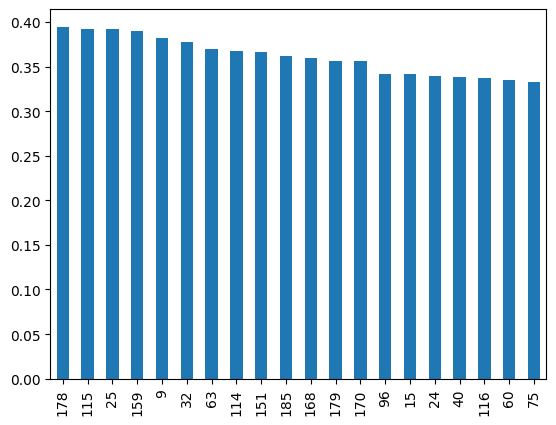

In [48]:
df_0['scores_0'][:20].plot(kind='bar')

C:\Users\varun\AppData\Local\Temp\ipykernel_2240\2426356649.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_1['scores_1'][:20].plot(kind='bar')


<AxesSubplot: >

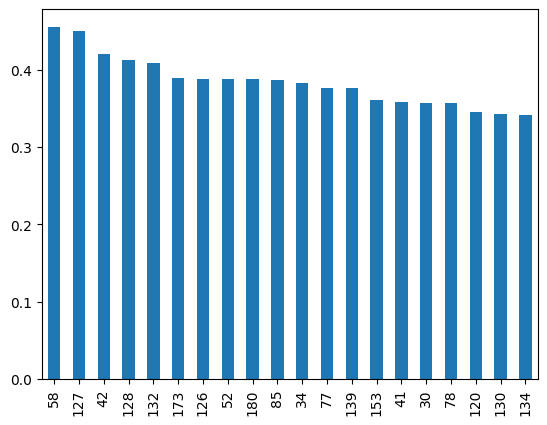

In [49]:
df_1['scores_1'][:20].plot(kind='bar')

In [53]:
df_0.sort_values(by='scores_0', ascending=False)[:10]

,document,scores_0
178,Discovery of Useful Questions as Auxiliary Tas...,0.394721
115,Rainbow: Combining Improvements in Deep Reinfo...,0.392221
25,Massively Parallel Methods for Deep Reinforcem...,0.391999
159,Simple Sensor Intentions for Exploration\nTim ...,0.389492
9,Neural Episodic Control\nAlexander Pritzel APR...,0.382246
32,Published as a conference paper at ICLR 2017\n...,0.377728
63,Deep Reinforcement Learning and the Deadly Tri...,0.369710
114,"July 8, 2019\nOn Inductive Biases in Deep Rein...",0.367074
151,Fast deep reinforcement learning using online\...,0.366646
185,Synthesizing Programs for Images using Reinfor...,0.361631


In [54]:
df_1.sort_values(by='scores_1', ascending=False)[:10]

,document,scores_1
58,Proceedings of Machine Learning Research vol 1...,0.455724
127,arXiv:2010.03531v1 [cs.LG] 7 Oct 2020Episodi...,0.450282
42,Optimistic Posterior Sampling for Reinforcemen...,0.419992
128,Kernel-Based Reinforcement Learning: A Finite-...,0.413230
132,UCB Momentum Q-learning:\nCorrecting the bias ...,0.409240
173,arXiv:1911.07676v2 [stat.ML] 19 Feb 2020Lear...,0.389249
126,A Kernel-Based Approach to Non-Stationary\nRei...,0.388356
52,Proceedings of Machine Learning Research vol 1...,0.388334
180,arXiv:2008.07353v1 [cs.LG] 17 Aug 2020On the...,0.388237
85,Information Directed Sampling for Linear Parti...,0.386532
